K fold: 10 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

2024-01-11 05:08:13.379489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 05:08:15.379476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 05:08:15.386183: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

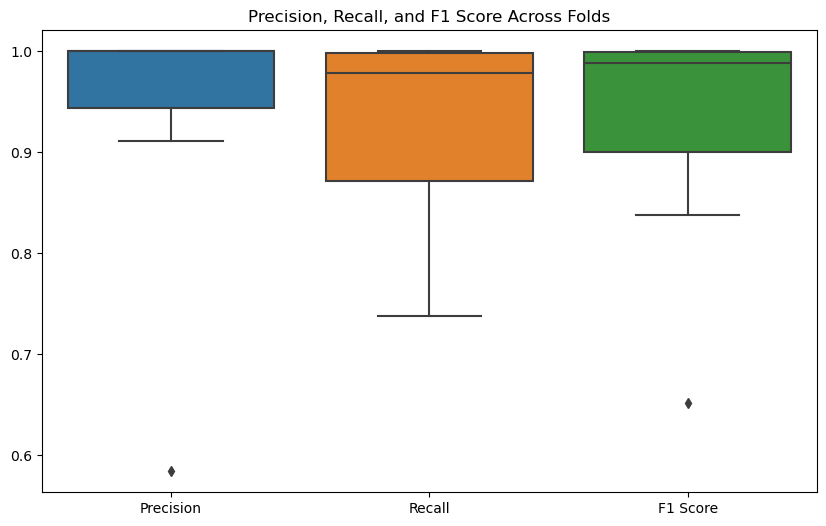


Summary of Results:
   Fold  Accuracy  Precision   Recall  F1 Score
0     1  0.606250   0.584158  0.73750  0.651934
1     2  0.856250   0.959677  0.74375  0.838028
2     3  0.903125   0.938776  0.86250  0.899023
3     4  0.906250   0.911392  0.90000  0.905660
4     5  1.000000   1.000000  1.00000  1.000000
5     6  0.996875   1.000000  0.99375  0.996865
6     7  0.981250   1.000000  0.96250  0.980892
7     8  1.000000   1.000000  1.00000  1.000000
8     9  0.996875   1.000000  0.99375  0.996865
9    10  1.000000   1.000000  1.00000  1.000000


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)


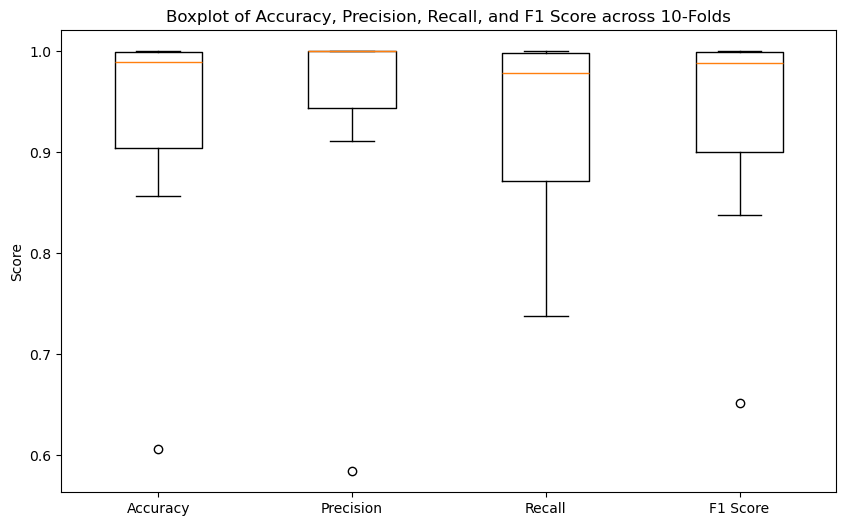

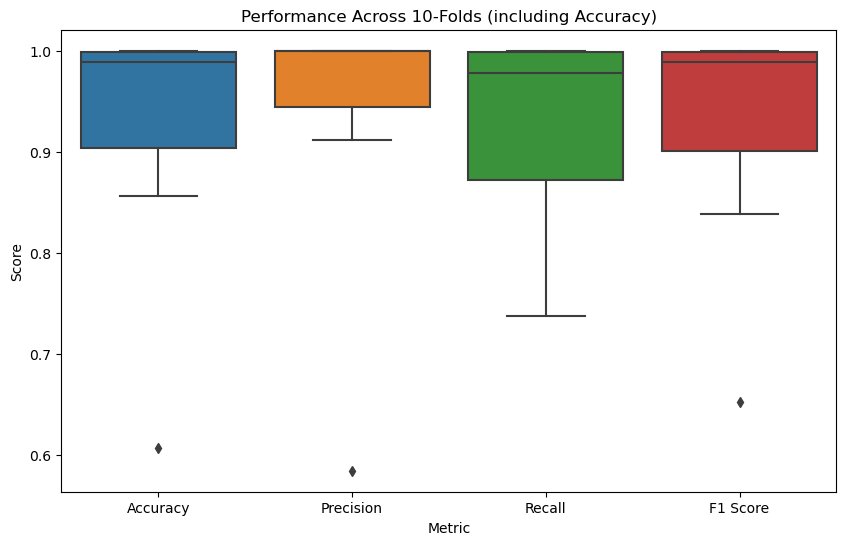


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
Accuracy     0.606250   0.924687        1.0
F1 Score     0.651934   0.926927        1.0
Precision    0.584158   0.939400        1.0
Recall       0.737500   0.919375        1.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data
accuracy_list = [0.606250, 0.856250, 0.903125, 0.906250, 1.000000, 0.996875, 0.981250, 1.000000, 0.996875, 1.000000]  # Replace with your actual accuracy values
precision_list = [0.584158, 0.959677, 0.938776, 0.911392, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall_list = [0.7375, 0.74375, 0.8625, 0.9, 1.0, 0.99375, 0.9625, 1.0, 0.99375, 1.0]
f1_list = [0.651934, 0.838028, 0.899023, 0.90566, 1.0, 0.996865, 0.980892, 1.0, 0.996865, 1.0]

# Combine the lists into a single list of lists
data = [accuracy_list, precision_list, recall_list, f1_list]  # Include accuracy in the data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Accuracy', 'Precision', 'Recall', 'F1 Score'])  # Adjust the labels

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Accuracy, Precision, Recall, and F1 Score across 10-Folds')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 4),  # Adjust the repeat value
    'Metric': ['Accuracy'] * 10 + ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,  # Adjust the categories
    'Score': accuracy_list + precision_list + recall_list + f1_list  # Include accuracy in the scores
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds (including Accuracy)')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)


K fold: 5 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


2024-01-07 06:42:30.869819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 06:42:32.256520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 06:42:32.264014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

1-11-23
This code below is for K fold: 5 folds, 80%-20% train/test split, but it includes evluation metrics, boxplot and summary table 

UPDATE: THIS IS THE ONE FOR 5 FOLD!

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

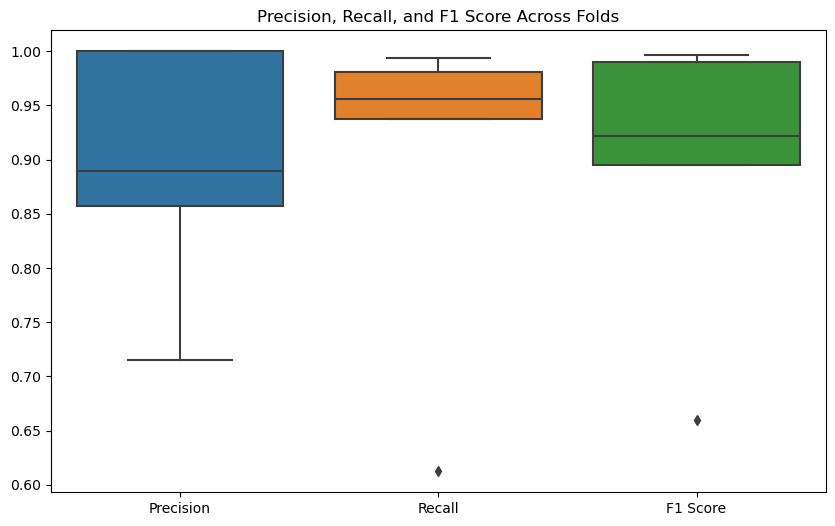


Summary of Results:
   Fold  Accuracy  Precision   Recall  F1 Score
0     1  0.684375   0.715328  0.61250  0.659933
1     2  0.890625   0.857143  0.93750  0.895522
2     3  0.918750   0.889535  0.95625  0.921687
3     4  0.990625   1.000000  0.98125  0.990536
4     5  0.996875   1.000000  0.99375  0.996865
Precision List: [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
Recall List: [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
F1 List: [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]


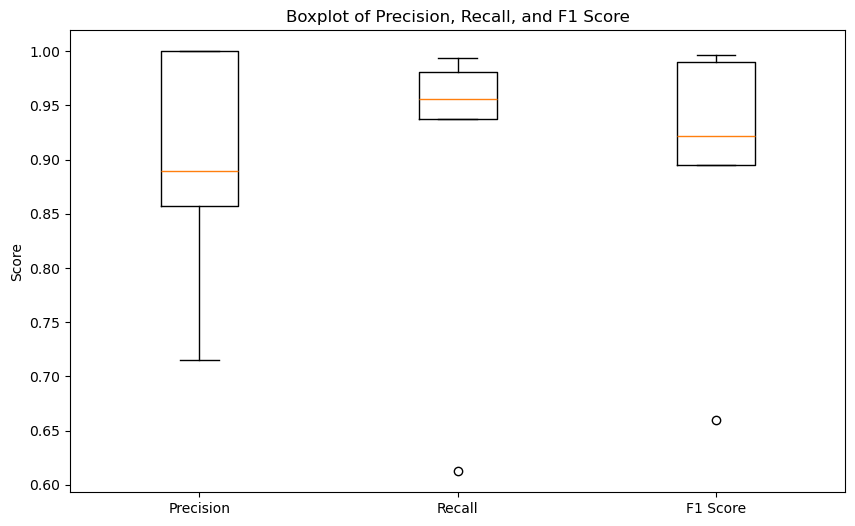

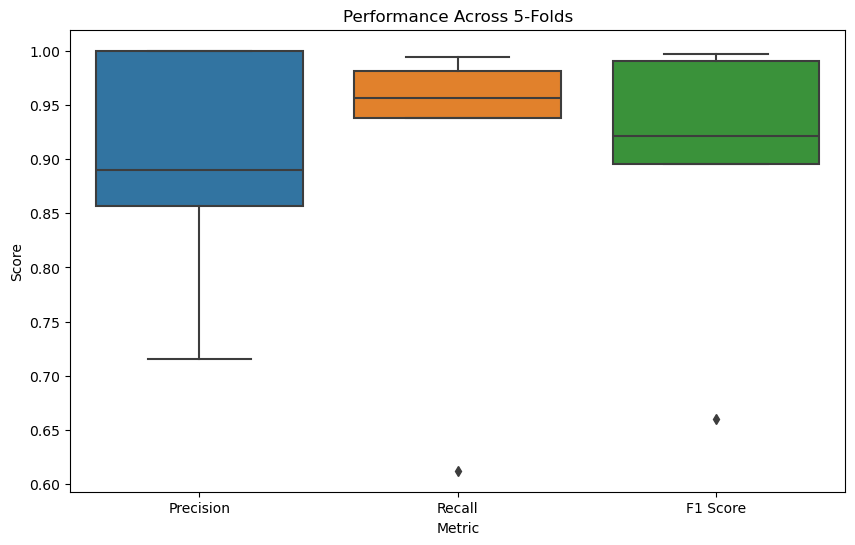


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
F1 Score     0.659933   0.892909   0.996865
Precision    0.715328   0.892401   1.000000
Recall       0.612500   0.896250   0.993750


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


import matplotlib.pyplot as plt


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



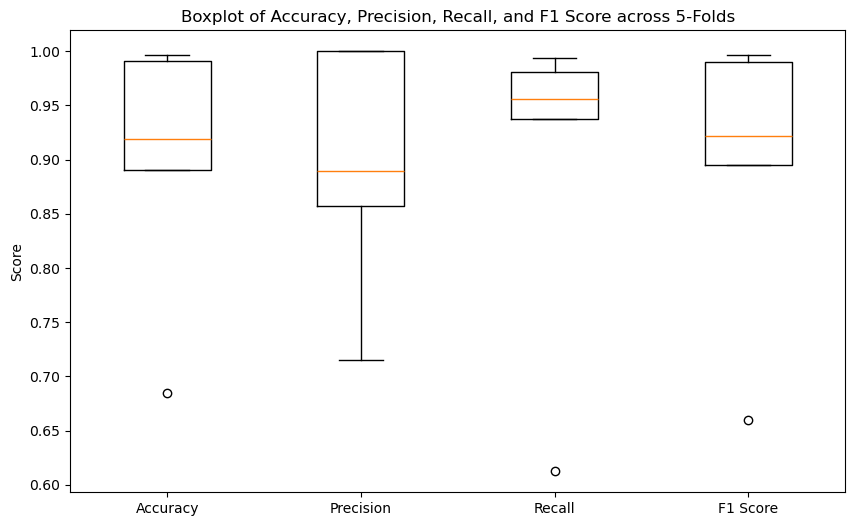

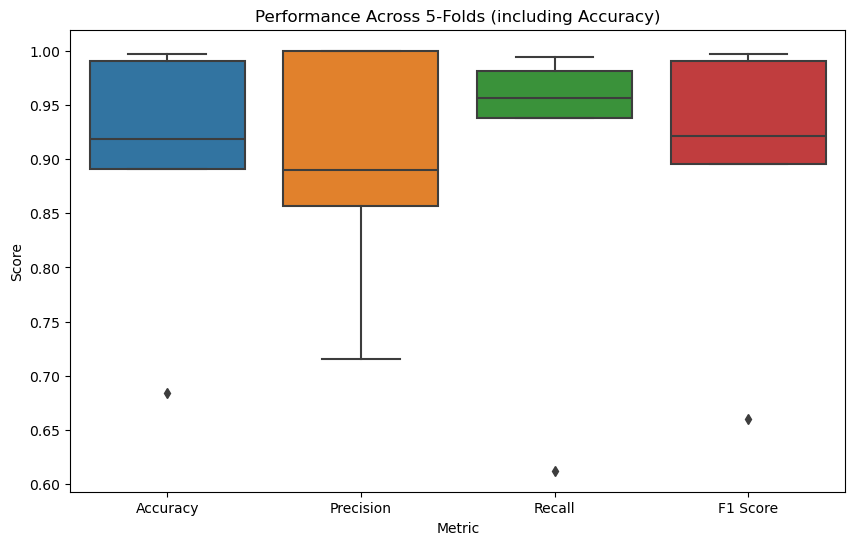


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
Accuracy     0.684375   0.896250   0.996875
F1 Score     0.659933   0.892909   0.996865
Precision    0.715328   0.892401   1.000000
Recall       0.612500   0.896250   0.993750


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Data
accuracy_list = [0.684375, 0.890625, 0.918750, 0.990625, 0.996875]  # Replace with your actual accuracy values
precision_list = [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
recall_list = [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
f1_list = [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]

# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score across 5-Folds')

# Show the plot
plt.show()
# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)

1-13-23:
Save Model Checkpoints:
SCRIPT BELOW CAN BE USED FOR INDEPDENT FOLDS (5 10, ANY)
10 folds INDEPENDENT OF 5 FOLDS
Investigate and implement a mechanism to save model checkpoints during training, ensuring essential information is included.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

2024-01-14 17:59:54.000776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 31s 632ms/step - loss: 0.8856 - accuracy: 0.6160
Epoch 2/60
45/45 [==============================] - 32s 704ms/step - loss: 0.5477 - accuracy: 0.7132
Epoch 3/60
45/45 [==============================] - 32s 714ms/step - loss: 0.5211 - accuracy: 0.7257
Epoch 4/60
45/45 [==============================] - 28s 633ms/step - loss: 0.4570 - accuracy: 0.7667
Epoch 5/60
45/45 [==============================] - 28s 613ms/step - loss: 0.4399 - accuracy: 0.7861
Epoch 6/60
45/45 [==============================] - 24s 522ms/step - loss: 0.5279 - accuracy: 0.7271
Epoch 7/60
45/45 [==============================] - 23s 504ms/step - loss: 0.4070 - accuracy: 0.8083
Epoch 8/60
45/45 [==============================] - 23s 505ms/step - loss: 0.3494 - accuracy: 0.8375
Epoch 9/60
45/45 [==============================] - 22s 497ms/step - loss: 0.3101 - accuracy: 0.8521
Epoch 10/60
45/45 [==============================] - 22s 491ms/step - loss: 0.2906 - accuracy: 0.8646


2024-01-14 18:25:53.018120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 2s 141ms/step - loss: 3.1990 - accuracy: 0.6469

Evaluation for Fold 1:
Test Loss: 3.199042558670044
Test Accuracy: 0.6468750238418579


2024-01-14 18:25:54.728585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 138ms/step

Fold 2 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold2/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 2 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold2/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 18:25:57.557459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 397ms/step - loss: 0.2133 - accuracy: 0.9431
Epoch 2/60
45/45 [==============================] - 18s 404ms/step - loss: 0.1091 - accuracy: 0.9653
Epoch 3/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0843 - accuracy: 0.9708
Epoch 4/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0584 - accuracy: 0.9799
Epoch 5/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0426 - accuracy: 0.9861
Epoch 6/60
45/45 [==============================] - 18s 398ms/step - loss: 0.0416 - accuracy: 0.9868
Epoch 7/60
45/45 [==============================] - 18s 398ms/step - loss: 0.0410 - accuracy: 0.9889
Epoch 8/60
45/45 [==============================] - 19s 410ms/step - loss: 0.1390 - accuracy: 0.9569
Epoch 9/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0383 - accuracy: 0.9840
Epoch 10/60
45/45 [==============================] - 18s 399ms/step - loss: 0.0242 - accuracy: 0.9917


2024-01-14 18:44:57.105860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 126ms/step - loss: 0.4884 - accuracy: 0.8938

Evaluation for Fold 2:
Test Loss: 0.4884452819824219
Test Accuracy: 0.893750011920929
 1/10 [==>...........................] - ETA: 1s

2024-01-14 18:44:58.600388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 111ms/step

Fold 3 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold3/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 3 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold3/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 18:45:00.054912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 415ms/step - loss: 0.1077 - accuracy: 0.9729
Epoch 2/60
45/45 [==============================] - 19s 416ms/step - loss: 0.0428 - accuracy: 0.9840
Epoch 3/60
45/45 [==============================] - 19s 425ms/step - loss: 0.0309 - accuracy: 0.9889
Epoch 4/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0254 - accuracy: 0.9882
Epoch 5/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0234 - accuracy: 0.9903
Epoch 6/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0206 - accuracy: 0.9937
Epoch 7/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0103 - accuracy: 0.9958
Epoch 8/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0094 - accuracy: 0.9965
Epoch 9/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0122 - accuracy: 0.9951
Epoch 10/60
45/45 [==============================] - 19s 421ms/step - loss: 0.0133 - accuracy: 0.9965


2024-01-14 19:04:50.715191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 119ms/step - loss: 0.1747 - accuracy: 0.9563

Evaluation for Fold 3:
Test Loss: 0.17474359273910522
Test Accuracy: 0.956250011920929
 1/10 [==>...........................] - ETA: 1s

2024-01-14 19:04:52.077321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 122ms/step

Fold 4 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold4/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 4 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold4/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 19:04:53.711289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 420ms/step - loss: 0.1113 - accuracy: 0.9708
Epoch 2/60
45/45 [==============================] - 19s 420ms/step - loss: 0.0782 - accuracy: 0.9778
Epoch 3/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0484 - accuracy: 0.9847
Epoch 4/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0171 - accuracy: 0.9944
Epoch 5/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0119 - accuracy: 0.9972
Epoch 6/60
45/45 [==============================] - 19s 413ms/step - loss: 0.2151 - accuracy: 0.9299
Epoch 7/60
45/45 [==============================] - 19s 425ms/step - loss: 0.2235 - accuracy: 0.9125
Epoch 8/60
45/45 [==============================] - 19s 421ms/step - loss: 0.0561 - accuracy: 0.9764
Epoch 9/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0408 - accuracy: 0.9868
Epoch 10/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0230 - accuracy: 0.9896


2024-01-14 19:24:17.818428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 137ms/step - loss: 0.1061 - accuracy: 0.9781

Evaluation for Fold 4:
Test Loss: 0.10609368234872818
Test Accuracy: 0.9781249761581421


2024-01-14 19:24:19.366105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 102ms/step

Fold 5 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold5/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 5 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold5/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 19:24:20.820722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 427ms/step - loss: 0.0492 - accuracy: 0.9882
Epoch 2/60
45/45 [==============================] - 19s 412ms/step - loss: 0.0174 - accuracy: 0.9931
Epoch 3/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0105 - accuracy: 0.9958
Epoch 4/60
45/45 [==============================] - 19s 424ms/step - loss: 0.0175 - accuracy: 0.9944
Epoch 5/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0370 - accuracy: 0.9896
Epoch 6/60
45/45 [==============================] - 18s 407ms/step - loss: 0.1310 - accuracy: 0.9625
Epoch 7/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0378 - accuracy: 0.9882
Epoch 8/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 9/60
45/45 [==============================] - 18s 400ms/step - loss: 0.0088 - accuracy: 0.9979
Epoch 10/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0042 - accuracy: 0.9979


2024-01-14 19:43:43.369704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 143ms/step - loss: 0.0149 - accuracy: 1.0000

Evaluation for Fold 5:
Test Loss: 0.01487732958048582
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-14 19:43:44.962602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 101ms/step

Fold 6 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold6/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 6 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold6/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 19:43:46.438381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 413ms/step - loss: 0.0251 - accuracy: 0.9937
Epoch 2/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0143 - accuracy: 0.9958
Epoch 3/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0075 - accuracy: 0.9979
Epoch 4/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0033 - accuracy: 0.9979
Epoch 5/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0075 - accuracy: 0.9972
Epoch 6/60
45/45 [==============================] - 19s 410ms/step - loss: 0.0115 - accuracy: 0.9944
Epoch 7/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0064 - accuracy: 0.9979
Epoch 8/60
45/45 [==============================] - 19s 407ms/step - loss: 0.0022 - accuracy: 0.9986
Epoch 9/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0058 - accuracy: 0.9972
Epoch 10/60
45/45 [==============================] - 19s 420ms/step - loss: 0.0014 - accuracy: 1.0000


2024-01-14 20:02:45.001140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 130ms/step - loss: 0.0063 - accuracy: 1.0000

Evaluation for Fold 6:
Test Loss: 0.0063432990573346615
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-14 20:02:46.487063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 126ms/step

Fold 7 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold7/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 7 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold7/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 20:02:48.152829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 424ms/step - loss: 0.1119 - accuracy: 0.9701
Epoch 2/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0358 - accuracy: 0.9896
Epoch 3/60
45/45 [==============================] - 19s 419ms/step - loss: 0.1294 - accuracy: 0.9778
Epoch 4/60
45/45 [==============================] - 18s 410ms/step - loss: 0.0824 - accuracy: 0.9785
Epoch 5/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0904 - accuracy: 0.9792
Epoch 6/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0142 - accuracy: 0.9965
Epoch 7/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0245 - accuracy: 0.9903
Epoch 8/60
45/45 [==============================] - 19s 412ms/step - loss: 0.0214 - accuracy: 0.9931
Epoch 9/60
45/45 [==============================] - 19s 412ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 10/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0061 - accuracy: 0.9993


2024-01-14 20:21:59.933751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 119ms/step - loss: 0.0610 - accuracy: 0.9781

Evaluation for Fold 7:
Test Loss: 0.061038605868816376
Test Accuracy: 0.9781249761581421
 1/10 [==>...........................] - ETA: 1s

2024-01-14 20:22:01.361316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 115ms/step

Fold 8 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold8/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 8 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold8/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 20:22:02.919422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 406ms/step - loss: 0.0353 - accuracy: 0.9896
Epoch 2/60
45/45 [==============================] - 19s 411ms/step - loss: 0.3027 - accuracy: 0.9403
Epoch 3/60
45/45 [==============================] - 19s 415ms/step - loss: 0.1649 - accuracy: 0.9368
Epoch 4/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0281 - accuracy: 0.9944
Epoch 5/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0085 - accuracy: 0.9951
Epoch 6/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0149 - accuracy: 0.9965
Epoch 7/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0172 - accuracy: 0.9937
Epoch 8/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0307 - accuracy: 0.9944
Epoch 9/60
45/45 [==============================] - 18s 408ms/step - loss: 0.0033 - accuracy: 0.9986
Epoch 10/60
45/45 [==============================] - 18s 402ms/step - loss: 0.0034 - accuracy: 0.9979


2024-01-14 20:40:54.190096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 141ms/step - loss: 0.0031 - accuracy: 1.0000

Evaluation for Fold 8:
Test Loss: 0.003148590447381139
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-14 20:40:55.778690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 124ms/step

Fold 9 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold9/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 9 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold9/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 20:40:57.391458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 417ms/step - loss: 0.0264 - accuracy: 0.9924
Epoch 2/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0335 - accuracy: 0.9875
Epoch 3/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0082 - accuracy: 0.9972
Epoch 4/60
45/45 [==============================] - 19s 412ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 5/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0102 - accuracy: 0.9937
Epoch 6/60
45/45 [==============================] - 19s 421ms/step - loss: 0.0180 - accuracy: 0.9937
Epoch 7/60
45/45 [==============================] - 19s 426ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 8/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0138 - accuracy: 0.9951
Epoch 9/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0065 - accuracy: 0.9972
Epoch 10/60
45/45 [==============================] - 18s 402ms/step - loss: 0.0104 - accuracy: 0.9965


2024-01-14 21:00:22.732102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 2s 144ms/step - loss: 1.3031e-04 - accuracy: 1.0000

Evaluation for Fold 9:
Test Loss: 0.00013030803529545665
Test Accuracy: 1.0


2024-01-14 21:00:24.370446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 99ms/step

Fold 10 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold10/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 10 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold10/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-14 21:00:25.770075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 413ms/step - loss: 4.8823e-04 - accuracy: 1.0000
Epoch 2/60
45/45 [==============================] - 19s 407ms/step - loss: 2.2007e-04 - accuracy: 1.0000
Epoch 3/60
45/45 [==============================] - 18s 394ms/step - loss: 5.3677e-04 - accuracy: 1.0000
Epoch 4/60
45/45 [==============================] - 18s 409ms/step - loss: 0.0023 - accuracy: 0.9993
Epoch 5/60
45/45 [==============================] - 18s 398ms/step - loss: 0.0029 - accuracy: 0.9986
Epoch 6/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0061 - accuracy: 0.9993
Epoch 7/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 8/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0078 - accuracy: 0.9986
Epoch 9/60
45/45 [==============================] - 18s 399ms/step - loss: 0.0012 - accuracy: 0.9993
Epoch 10/60
45/45 [==============================] - 19s 406ms/step - loss: 0.0039 - accur

2024-01-14 21:19:16.153170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 121ms/step - loss: 1.9930e-04 - accuracy: 1.0000

Evaluation for Fold 10:
Test Loss: 0.00019929904374293983
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-14 21:19:17.608352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 101ms/step


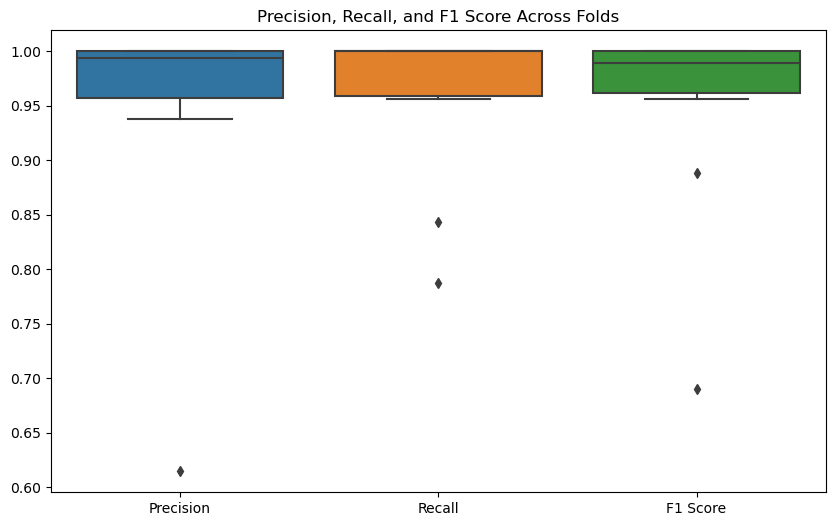

ValueError: All arrays must be of the same length

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



1-16-23
10 fold based on 5 fold model (dependent training)

2024-01-16 09:09:27.259848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 09:09:31.611620: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Fold 6 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold6/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 6 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold6/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-16 09:09:38.517371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 34s 695ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 2/60
45/45 [==============================] - 30s 656ms/step - loss: 0.0445 - accuracy: 0.9882
Epoch 3/60
45/45 [==============================] - 26s 582ms/step - loss: 0.0132 - accuracy: 0.9931
Epoch 4/60
45/45 [==============================] - 25s 542ms/step - loss: 0.0045 - accuracy: 0.9979
Epoch 5/60
45/45 [==============================] - 22s 480ms/step - loss: 0.0058 - accuracy: 0.9972
Epoch 6/60
45/45 [==============================] - 22s 493ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 7/60
45/45 [==============================] - 23s 497ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 8/60
45/45 [==============================] - 22s 493ms/step - loss: 0.0087 - accuracy: 0.9972
Epoch 9/60
45/45 [==============================] - 22s 478ms/step - loss: 0.0060 - accuracy: 0.9972
Epoch 10/60
45/45 [==============================] - 21s 467ms/step - loss: 0.0057 - accuracy: 0.9979


2024-01-16 09:29:57.879616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 126ms/step - loss: 0.0031 - accuracy: 1.0000

Evaluation for Fold 6:
Test Loss: 0.0030971230007708073
Test Accuracy: 1.0


2024-01-16 09:29:59.463214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 112ms/step

Fold 7 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold7/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 7 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold7/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-16 09:30:00.998726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 406ms/step - loss: 0.0065 - accuracy: 0.9972
Epoch 2/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0063 - accuracy: 0.9986
Epoch 3/60
45/45 [==============================] - 18s 406ms/step - loss: 9.9189e-04 - accuracy: 0.9993
Epoch 4/60
45/45 [==============================] - 19s 412ms/step - loss: 2.3236e-04 - accuracy: 1.0000
Epoch 5/60
45/45 [==============================] - 19s 407ms/step - loss: 0.0214 - accuracy: 0.9931
Epoch 6/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0108 - accuracy: 0.9965
Epoch 7/60
45/45 [==============================] - 18s 400ms/step - loss: 0.0017 - accuracy: 0.9993
Epoch 8/60
45/45 [==============================] - 18s 396ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 9/60
45/45 [==============================] - 18s 402ms/step - loss: 0.0021 - accuracy: 0.9993
Epoch 10/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0021 - accuracy:

2024-01-16 09:49:01.019161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 131ms/step - loss: 9.0481e-04 - accuracy: 1.0000

Evaluation for Fold 7:
Test Loss: 0.0009048145147971809
Test Accuracy: 1.0


2024-01-16 09:49:02.533114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 99ms/step

Fold 8 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold8/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 8 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold8/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-16 09:49:04.026164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 406ms/step - loss: 0.0144 - accuracy: 0.9924
Epoch 2/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0027 - accuracy: 0.9979
Epoch 3/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0071 - accuracy: 0.9986
Epoch 4/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0476 - accuracy: 0.9847
Epoch 5/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0071 - accuracy: 0.9979
Epoch 6/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0035 - accuracy: 0.9993
Epoch 7/60
45/45 [==============================] - 18s 402ms/step - loss: 0.0197 - accuracy: 0.9951
Epoch 8/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0160 - accuracy: 0.9965
Epoch 9/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0071 - accuracy: 0.9979
Epoch 10/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0050 - accuracy: 0.9986


2024-01-16 10:07:48.896775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 112ms/step - loss: 2.9920e-05 - accuracy: 1.0000

Evaluation for Fold 8:
Test Loss: 2.9920463930466212e-05
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-16 10:07:50.236540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 118ms/step

Fold 9 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold9/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 9 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold9/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-16 10:07:51.825874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 408ms/step - loss: 0.0140 - accuracy: 0.9958
Epoch 2/60
45/45 [==============================] - 18s 405ms/step - loss: 0.0338 - accuracy: 0.9917
Epoch 3/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0240 - accuracy: 0.9951
Epoch 4/60
45/45 [==============================] - 19s 408ms/step - loss: 0.0248 - accuracy: 0.9951
Epoch 5/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0255 - accuracy: 0.9931
Epoch 6/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0119 - accuracy: 0.9965
Epoch 7/60
45/45 [==============================] - 19s 416ms/step - loss: 0.0051 - accuracy: 0.9979
Epoch 8/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0082 - accuracy: 0.9965
Epoch 9/60
45/45 [==============================] - 19s 408ms/step - loss: 0.0119 - accuracy: 0.9958
Epoch 10/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0037 - accuracy: 0.9986


2024-01-16 10:26:46.093097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 129ms/step - loss: 4.4924e-05 - accuracy: 1.0000

Evaluation for Fold 9:
Test Loss: 4.4924072426510975e-05
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-16 10:26:47.658016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 132ms/step

Fold 10 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold10/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 10 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split/fold10/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-16 10:26:50.435852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 412ms/step - loss: 6.0836e-04 - accuracy: 1.0000
Epoch 2/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 3/60
45/45 [==============================] - 19s 416ms/step - loss: 0.0037 - accuracy: 0.9986
Epoch 4/60
45/45 [==============================] - 19s 412ms/step - loss: 4.4894e-04 - accuracy: 1.0000
Epoch 5/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0021 - accuracy: 0.9993
Epoch 6/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0030 - accuracy: 0.9986
Epoch 7/60
45/45 [==============================] - 19s 409ms/step - loss: 3.2706e-04 - accuracy: 1.0000
Epoch 8/60
45/45 [==============================] - 19s 410ms/step - loss: 2.1021e-04 - accuracy: 1.0000
Epoch 9/60
45/45 [==============================] - 19s 418ms/step - loss: 1.0039e-04 - accuracy: 1.0000
Epoch 10/60
45/45 [==============================] - 18s 405ms/step - loss: 6.6640

2024-01-16 10:45:53.431123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 122ms/step - loss: 0.0014 - accuracy: 1.0000

Evaluation for Fold 10:
Test Loss: 0.001363915391266346
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-16 10:45:54.846072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 95ms/step


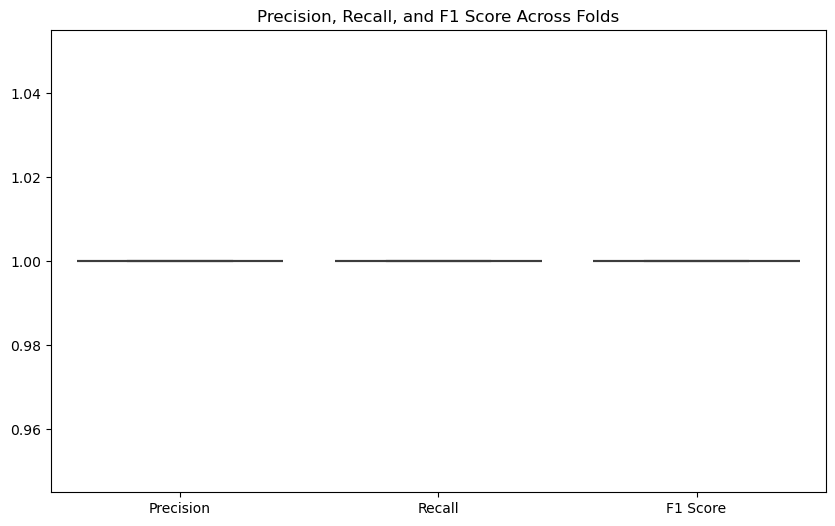

ValueError: All arrays must be of the same length

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'


# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Load the entire model from the file
model = load_model('/home/wangg/REU-Hearing-Loss-Project-1/machine learning/checkpoint results/10 folds 80_20 split/dependentModel/model/10fold_model_fold_5.h5')


# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(6, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(6, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



In [3]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())
print("Results File Location:", os.path.abspath(results_filename))


Current Working Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning


NameError: name 'results_filename' is not defined

K fold: 10 Folds, 90% training, 10% testing split. (2 HI, 2 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 90-10 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


2023-11-24 15:48:43.961558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________


2023-11-24 15:48:48.538831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 15:48:48.544169: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0         
 2D)                                                             
          

In [2]:

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-10: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-10: {std_accuracy}')


Accuracies for each fold:
Fold 1: 0.731249988079071
Fold 2: 0.9312499761581421
Fold 3: 0.9937499761581421
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 1.0
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 1.0

Average Accuracy across Folds 1-10: 0.9656249940395355
Standard Deviation of Accuracy across Folds 1-10: 0.08073152242833005


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



2024-01-17 08:50:20.221559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 08:50:21.424675: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

2024-01-17 08:50:21.970898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 22s 455ms/step - loss: 1.1955 - accuracy: 0.5861
Epoch 2/60
45/45 [==============================] - 19s 416ms/step - loss: 0.5882 - accuracy: 0.6917
Epoch 3/60
45/45 [==============================] - 19s 422ms/step - loss: 0.5616 - accuracy: 0.7097
Epoch 4/60
45/45 [==============================] - 20s 435ms/step - loss: 0.5132 - accuracy: 0.7368
Epoch 5/60
45/45 [==============================] - 20s 432ms/step - loss: 0.5000 - accuracy: 0.7451
Epoch 6/60
45/45 [==============================] - 20s 439ms/step - loss: 0.4574 - accuracy: 0.7674
Epoch 7/60
45/45 [==============================] - 20s 442ms/step - loss: 0.4044 - accuracy: 0.8056
Epoch 8/60
45/45 [==============================] - 19s 432ms/step - loss: 0.3851 - accuracy: 0.8194
Epoch 9/60
45/45 [==============================] - 20s 432ms/step - loss: 0.3388 - accuracy: 0.8500
Epoch 10/60
45/45 [==============================] - 20s 437ms/step - loss: 0.3252 - accuracy: 0.8486


2024-01-17 09:10:41.042728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 122ms/step - loss: 2.9407 - accuracy: 0.6531

Evaluation for Fold 1:
Test Loss: 2.940749406814575
Test Accuracy: 0.653124988079071


2024-01-17 09:10:42.659712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 100ms/step

Fold 2 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold2/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 2 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold2/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 09:10:44.184680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 429ms/step - loss: 0.2519 - accuracy: 0.9215
Epoch 2/60
45/45 [==============================] - 20s 438ms/step - loss: 0.1326 - accuracy: 0.9563
Epoch 3/60
45/45 [==============================] - 19s 425ms/step - loss: 0.1075 - accuracy: 0.9597
Epoch 4/60
45/45 [==============================] - 19s 428ms/step - loss: 0.0569 - accuracy: 0.9826
Epoch 5/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0513 - accuracy: 0.9847
Epoch 6/60
45/45 [==============================] - 19s 425ms/step - loss: 0.0494 - accuracy: 0.9792
Epoch 7/60
45/45 [==============================] - 20s 432ms/step - loss: 0.0402 - accuracy: 0.9896
Epoch 8/60
45/45 [==============================] - 19s 430ms/step - loss: 0.0834 - accuracy: 0.9715
Epoch 9/60
45/45 [==============================] - 19s 427ms/step - loss: 0.0345 - accuracy: 0.9868
Epoch 10/60
45/45 [==============================] - 19s 427ms/step - loss: 0.0384 - accuracy: 0.9868


2024-01-17 09:30:25.066791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 118ms/step - loss: 0.3828 - accuracy: 0.8750

Evaluation for Fold 2:
Test Loss: 0.3828320801258087
Test Accuracy: 0.875
 1/10 [==>...........................] - ETA: 1s

2024-01-17 09:30:26.468603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 111ms/step

Fold 3 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold3/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 3 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold3/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 09:30:27.924474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 20s 450ms/step - loss: 0.2297 - accuracy: 0.9264
Epoch 2/60
45/45 [==============================] - 20s 443ms/step - loss: 0.0648 - accuracy: 0.9743
Epoch 3/60
45/45 [==============================] - 20s 437ms/step - loss: 0.0367 - accuracy: 0.9903
Epoch 4/60
45/45 [==============================] - 20s 439ms/step - loss: 0.0393 - accuracy: 0.9868
Epoch 5/60
45/45 [==============================] - 20s 448ms/step - loss: 0.0332 - accuracy: 0.9903
Epoch 6/60
45/45 [==============================] - 20s 436ms/step - loss: 0.0165 - accuracy: 0.9944
Epoch 7/60
45/45 [==============================] - 20s 448ms/step - loss: 0.0299 - accuracy: 0.9910
Epoch 8/60
45/45 [==============================] - 20s 438ms/step - loss: 0.0105 - accuracy: 0.9965
Epoch 9/60
45/45 [==============================] - 20s 434ms/step - loss: 0.0077 - accuracy: 0.9972
Epoch 10/60
45/45 [==============================] - 20s 434ms/step - loss: 0.0059 - accuracy: 0.9993


2024-01-17 09:50:32.904283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 143ms/step - loss: 0.1507 - accuracy: 0.9594

Evaluation for Fold 3:
Test Loss: 0.1507255733013153
Test Accuracy: 0.9593750238418579
 1/10 [==>...........................] - ETA: 1s

2024-01-17 09:50:34.541187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 2s 158ms/step

Fold 4 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold4/Training
Found 1480 images belonging to 2 classes.
Number of Training Samples: 1480

Fold 4 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold4/Testing
Found 280 images belonging to 2 classes.
Number of Test Samples: 280
Epoch 1/60


2024-01-17 09:50:37.298041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


46/46 [==============================] - 20s 423ms/step - loss: 0.0842 - accuracy: 0.9751
Epoch 2/60
46/46 [==============================] - 20s 423ms/step - loss: 0.0317 - accuracy: 0.9890
Epoch 3/60
46/46 [==============================] - 19s 417ms/step - loss: 0.0443 - accuracy: 0.9890
Epoch 4/60
46/46 [==============================] - 20s 421ms/step - loss: 0.0158 - accuracy: 0.9938
Epoch 5/60
46/46 [==============================] - 20s 432ms/step - loss: 0.0100 - accuracy: 0.9972
Epoch 6/60
46/46 [==============================] - 20s 435ms/step - loss: 0.0232 - accuracy: 0.9938
Epoch 7/60
46/46 [==============================] - 20s 429ms/step - loss: 0.0104 - accuracy: 0.9959
Epoch 8/60
46/46 [==============================] - 20s 435ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 9/60
46/46 [==============================] - 20s 427ms/step - loss: 0.0079 - accuracy: 0.9965
Epoch 10/60
46/46 [==============================] - 20s 426ms/step - loss: 0.0134 - accuracy: 0.9965


2024-01-17 10:11:01.320889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 1s 130ms/step - loss: 0.1311 - accuracy: 0.9453

Evaluation for Fold 4:
Test Loss: 0.13105818629264832
Test Accuracy: 0.9453125
1/8 [==>...........................] - ETA: 1s

2024-01-17 10:11:02.599039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 1s 110ms/step


ValueError: Found input variables with inconsistent numbers of samples: [280, 256]


Fold 4 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold4/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 4 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold4/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 10:30:09.669338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 406ms/step - loss: 0.0506 - accuracy: 0.9847
Epoch 2/60
45/45 [==============================] - 19s 416ms/step - loss: 0.0577 - accuracy: 0.9826
Epoch 3/60
45/45 [==============================] - 19s 430ms/step - loss: 0.0727 - accuracy: 0.9799
Epoch 4/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0275 - accuracy: 0.9910
Epoch 5/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0217 - accuracy: 0.9917
Epoch 6/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0139 - accuracy: 0.9965
Epoch 7/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0072 - accuracy: 0.9979
Epoch 8/60
45/45 [==============================] - 18s 404ms/step - loss: 0.0081 - accuracy: 0.9979
Epoch 9/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0074 - accuracy: 0.9979
Epoch 10/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0049 - accuracy: 0.9979


2024-01-17 10:49:12.607036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 121ms/step - loss: 0.0114 - accuracy: 0.9969

Evaluation for Fold 4:
Test Loss: 0.011414186097681522
Test Accuracy: 0.996874988079071


2024-01-17 10:49:14.137110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 126ms/step

Fold 5 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold5/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 5 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold5/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 10:49:15.831570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 417ms/step - loss: 0.0420 - accuracy: 0.9889
Epoch 2/60
45/45 [==============================] - 18s 408ms/step - loss: 0.0981 - accuracy: 0.9674
Epoch 3/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0445 - accuracy: 0.9854
Epoch 4/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0109 - accuracy: 0.9951
Epoch 5/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0236 - accuracy: 0.9944
Epoch 6/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0096 - accuracy: 0.9958
Epoch 7/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0037 - accuracy: 0.9986
Epoch 8/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0045 - accuracy: 0.9979
Epoch 9/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0117 - accuracy: 0.9944
Epoch 10/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0049 - accuracy: 0.9986


2024-01-17 11:08:29.506927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 131ms/step - loss: 0.0365 - accuracy: 0.9875

Evaluation for Fold 5:
Test Loss: 0.03649797663092613
Test Accuracy: 0.987500011920929
 1/10 [==>...........................] - ETA: 1s

2024-01-17 11:08:31.099967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 99ms/step

Fold 6 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold6/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 6 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold6/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 11:08:32.575950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 18s 409ms/step - loss: 0.0182 - accuracy: 0.9931
Epoch 2/60
45/45 [==============================] - 18s 403ms/step - loss: 0.0108 - accuracy: 0.9944
Epoch 3/60
45/45 [==============================] - 19s 412ms/step - loss: 0.0060 - accuracy: 0.9986
Epoch 4/60
45/45 [==============================] - 19s 418ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 5/60
45/45 [==============================] - 19s 416ms/step - loss: 0.0115 - accuracy: 0.9972
Epoch 6/60
45/45 [==============================] - 19s 410ms/step - loss: 0.0045 - accuracy: 0.9972
Epoch 7/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0330 - accuracy: 0.9868
Epoch 8/60
45/45 [==============================] - 19s 422ms/step - loss: 0.0747 - accuracy: 0.9792
Epoch 9/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0290 - accuracy: 0.9903
Epoch 10/60
45/45 [==============================] - 19s 421ms/step - loss: 0.0064 - accuracy: 0.9993


2024-01-17 11:27:47.366121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 134ms/step - loss: 0.0090 - accuracy: 0.9969

Evaluation for Fold 6:
Test Loss: 0.0090372608974576
Test Accuracy: 0.996874988079071
 1/10 [==>...........................] - ETA: 1s

2024-01-17 11:27:48.930219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 102ms/step

Fold 7 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold7/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 7 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold7/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 11:27:50.401201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 412ms/step - loss: 0.0207 - accuracy: 0.9937
Epoch 2/60
45/45 [==============================] - 19s 426ms/step - loss: 0.0090 - accuracy: 0.9958
Epoch 3/60
45/45 [==============================] - 19s 424ms/step - loss: 0.0193 - accuracy: 0.9910
Epoch 4/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0404 - accuracy: 0.9854
Epoch 5/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0149 - accuracy: 0.9931
Epoch 6/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0135 - accuracy: 0.9958
Epoch 7/60
45/45 [==============================] - 19s 421ms/step - loss: 0.0191 - accuracy: 0.9937
Epoch 8/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0039 - accuracy: 0.9986
Epoch 9/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0034 - accuracy: 0.9993
Epoch 10/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0056 - accuracy: 0.9972


2024-01-17 11:46:48.898468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 137ms/step - loss: 0.0270 - accuracy: 0.9937

Evaluation for Fold 7:
Test Loss: 0.0269752349704504
Test Accuracy: 0.9937499761581421
 1/10 [==>...........................] - ETA: 1s

2024-01-17 11:46:50.473017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 110ms/step

Fold 8 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold8/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 8 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold8/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 11:46:51.995802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 413ms/step - loss: 0.0083 - accuracy: 0.9986
Epoch 2/60
45/45 [==============================] - 19s 414ms/step - loss: 0.1306 - accuracy: 0.9799
Epoch 3/60
45/45 [==============================] - 19s 417ms/step - loss: 0.0594 - accuracy: 0.9840
Epoch 4/60
45/45 [==============================] - 19s 411ms/step - loss: 0.0116 - accuracy: 0.9958
Epoch 5/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 6/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0064 - accuracy: 0.9972
Epoch 7/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 8/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0048 - accuracy: 0.9986
Epoch 9/60
45/45 [==============================] - 18s 406ms/step - loss: 7.8728e-04 - accuracy: 1.0000
Epoch 10/60
45/45 [==============================] - 19s 414ms/step - loss: 6.4272e-04 - accuracy:

2024-01-17 12:05:58.749324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 114ms/step - loss: 0.0029 - accuracy: 1.0000

Evaluation for Fold 8:
Test Loss: 0.0028834848199039698
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-17 12:06:00.113396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 97ms/step

Fold 9 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold9/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 9 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold9/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 12:06:01.510857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 425ms/step - loss: 0.0109 - accuracy: 0.9958
Epoch 2/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0039 - accuracy: 0.9979
Epoch 3/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0116 - accuracy: 0.9972
Epoch 4/60
45/45 [==============================] - 19s 414ms/step - loss: 0.0091 - accuracy: 0.9965
Epoch 5/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0119 - accuracy: 0.9944
Epoch 6/60
45/45 [==============================] - 19s 423ms/step - loss: 0.0048 - accuracy: 0.9979
Epoch 7/60
45/45 [==============================] - 19s 413ms/step - loss: 0.0017 - accuracy: 0.9986
Epoch 8/60
45/45 [==============================] - 19s 414ms/step - loss: 7.3902e-04 - accuracy: 1.0000
Epoch 9/60
45/45 [==============================] - 19s 424ms/step - loss: 0.0075 - accuracy: 0.9986
Epoch 10/60
45/45 [==============================] - 19s 418ms/step - loss: 0.0109 - accuracy: 0.9

2024-01-17 12:25:16.617734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 127ms/step - loss: 8.6986e-06 - accuracy: 1.0000

Evaluation for Fold 9:
Test Loss: 8.69862469699001e-06
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-17 12:25:18.082151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 115ms/step

Fold 10 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold10/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 10 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)/fold10/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60


2024-01-17 12:25:19.613966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 414ms/step - loss: 0.0156 - accuracy: 0.9951
Epoch 2/60
45/45 [==============================] - 18s 406ms/step - loss: 0.0176 - accuracy: 0.9965
Epoch 3/60
45/45 [==============================] - 19s 408ms/step - loss: 0.0055 - accuracy: 0.9979
Epoch 4/60
45/45 [==============================] - 19s 419ms/step - loss: 0.0062 - accuracy: 0.9986
Epoch 5/60
45/45 [==============================] - 19s 409ms/step - loss: 0.0030 - accuracy: 0.9986
Epoch 6/60
45/45 [==============================] - 19s 416ms/step - loss: 0.2193 - accuracy: 0.9681
Epoch 7/60
45/45 [==============================] - 18s 405ms/step - loss: 0.5523 - accuracy: 0.8764
Epoch 8/60
45/45 [==============================] - 19s 422ms/step - loss: 0.0988 - accuracy: 0.9660
Epoch 9/60
45/45 [==============================] - 19s 415ms/step - loss: 0.0226 - accuracy: 0.9917
Epoch 10/60
45/45 [==============================] - 18s 407ms/step - loss: 0.0095 - accuracy: 0.9972


2024-01-17 12:44:23.223034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 137ms/step - loss: 1.4350e-04 - accuracy: 1.0000

Evaluation for Fold 10:
Test Loss: 0.0001434986770618707
Test Accuracy: 1.0
 1/10 [==>...........................] - ETA: 1s

2024-01-17 12:44:24.842138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 119ms/step


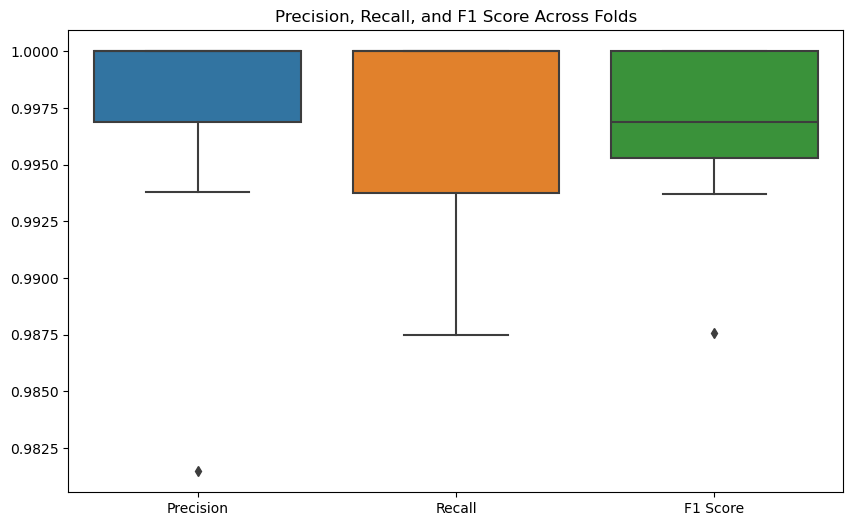


Summary of Results:
   Fold  Accuracy  Precision   Recall  F1 Score
0     4  0.996875   0.993789  1.00000  0.996885
1     5  0.987500   0.981481  0.99375  0.987578
2     6  0.996875   1.000000  0.99375  0.996865
3     7  0.993750   1.000000  0.98750  0.993711
4     8  1.000000   1.000000  1.00000  1.000000
5     9  1.000000   1.000000  1.00000  1.000000
6    10  1.000000   1.000000  1.00000  1.000000
Precision List: [0.9937888198757764, 0.9814814814814815, 1.0, 1.0, 1.0, 1.0, 1.0]
Recall List: [1.0, 0.99375, 0.99375, 0.9875, 1.0, 1.0, 1.0]
F1 List: [0.9968847352024921, 0.9875776397515528, 0.9968652037617556, 0.9937106918238994, 1.0, 1.0, 1.0]


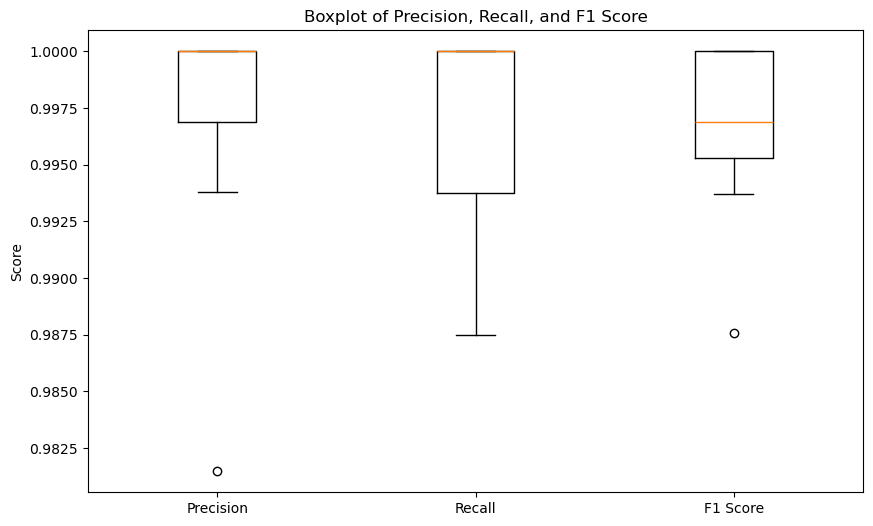

ValueError: All arrays must be of the same length

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'


# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Load the entire model from the file
model = load_model('/home/wangg/REU-Hearing-Loss-Project-1/machine learning/checkpoint results/10folds - 80-20 train test split (includes all subjects)/model/10fold_model_fold_3.h5')


# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(4, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(4, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(4, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)

